In [1]:
!wget "https://www.taketours.com/images/tour_photos/2018-08/640/2281169-1534875053-1.jpeg" -O "rushmore2.jpg"

--2019-05-05 10:35:32--  https://www.taketours.com/images/tour_photos/2018-08/640/2281169-1534875053-1.jpeg
Resolving www.taketours.com (www.taketours.com)... 104.26.4.9, 104.26.5.9, 2606:4700:20::681a:509, ...
Connecting to www.taketours.com (www.taketours.com)|104.26.4.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84219 (82K) [image/jpeg]
Saving to: 'rushmore2.jpg'

rushmore2.jpg       100%[===================>]  82.25K  --.-KB/s    in 0.001s  

2019-05-05 10:35:33 (81.4 MB/s) - 'rushmore2.jpg' saved [84219/84219]



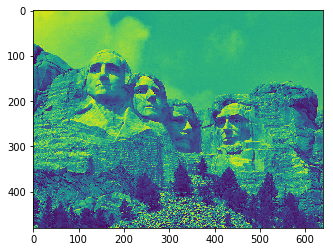

In [26]:
from PIL import Image
import numpy
from pylab import *
import cv2
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

image = Image.open('rushmore2.jpg')
image = numpy.array(image)

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(image)

In [2]:
flip_image = image[:,::-1]

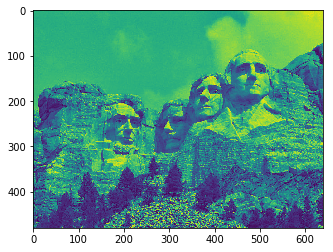

In [3]:
plt.imshow(flip_image)

In [4]:
def conviulutionKernel(kernelList, inputImage):
    kernelSizeXY = 3
    results = np.zeros((inputImage.shape))
    for yPosition in range(inputImage.shape[0]-kernelSizeXY):
        for xPosition in range(inputImage.shape[1]-kernelSizeXY):
            windowArea = inputImage[yPosition:yPosition+kernelSizeXY,
                                        xPosition:xPosition+kernelSizeXY]
            appliedKernel = windowArea * kernelList
            results[yPosition, xPosition] = np.sum(appliedKernel)
    return results

In [5]:
import scipy.stats as st
# https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy
def gkern(kernlen=3, nsig=3):
    lim = kernlen//2 + (kernlen % 2)/2
    x = np.linspace(-lim, lim, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

In [9]:
def harris(x, y, image):
    image_x = x ** 2
    image_xy = x * y
    image_y = y ** 2
  
    image_x_gausian = conviulutionKernel(gkern(), image_x)
    image_xy_gausian = conviulutionKernel(gkern(), image_xy)
    image_y_gausian = conviulutionKernel(gkern(), image_y)

    harris_set = []
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            # like the conviulutionKernel function
            h_x = np.sum(image_x_gausian[y:y+1, x:x+1])
            h_xy = np.sum(image_xy_gausian[y:y+1, x:x+1])
            h_y = np.sum(image_y_gausian[y:y+1, x:x+1])

            alpha = 0.06

            det = (h_x * h_y) - (h_xy ** 2)
            r = det - alpha * ( (h_x + h_y) ** 2)
            
            if(r < 0):
                harris_set.append([x, y, -np.log10(np.abs(r))])
            elif(r > 0):
                harris_set.append([x, y, np.log10(np.abs(r))]) 
    return harris_set

In [10]:
def filter_image(input_image):
    kernel_x = np.array(([1, 2, 1],
                         [0, 0, 0],
                         [-1, -2, -1]))
    kernel_y = np.array(([-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]))
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    print(input_image.shape)

    x = conviulutionKernel(kernel_x, input_image)
    y = conviulutionKernel(kernel_y, input_image)
    ax[0].imshow( x )
    ax[1].imshow( y )
    return harris(x, y, input_image)

(480, 640)


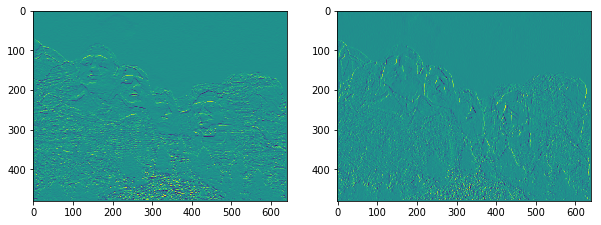

In [11]:
harris_resposne_1 = filter_image(image)

(480, 640)


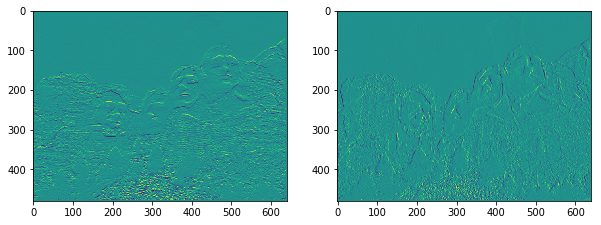

In [12]:
harris_resposne_2 = filter_image(flip_image)

In [13]:
def mark_coordinate(image, x_y):
    x, y = x_y
    square_size = 18
    for j in range(square_size):
        for i in range(square_size):
            if((y + j) < image.shape[0] - 1 and (x + i) < image.shape[1] - 1):
                image[y + j ,x + i] = 255   

In [16]:
def clean_harris(response, input_image):
    new_harris = []
    # interested in features with certain threshold
    for j in range(len(response)):
        if(-12 < response[j][2] < -10):
            new_harris.append(response[j])
    
    copy_image = input_image.copy()
    for response in new_harris:
        x, y, r = response
        mark_coordinate(copy_image, (x, y))
    plt.imshow(copy_image)
    return new_harris

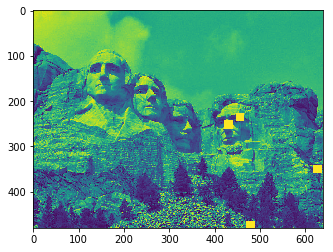

In [17]:
clean_harris_1 = clean_harris(harris_resposne_1, image)

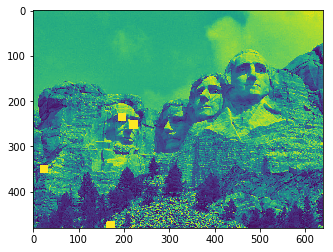

In [18]:
clean_harris_2 = clean_harris(harris_resposne_2, flip_image)

In [19]:
def MSE(feature_1, feature_2):
    return np.sqrt((feature_1-feature_2) ** 2)

In [20]:
combined_image = np.zeros((image.shape[0], image.shape[1] * 2))
combined_image[:, :image.shape[1]] = image
combined_image[:, image.shape[1]:] = flip_image

In [41]:
def get_coefficient(x, y, x1, y1):
    # y - y0= a*(x - x0)
    delta = (y1-y)/(x1-x)
    return delta

In [42]:
def draw_line(input_image, x, y, x1, y1):
    start = (x, y)
    end = (x1, y1)
    
    delta = get_coefficient(start[0], start[1], end[0], end[1])
    for new_x in range(start[0], end[0]):
        target = (delta * (new_x - start[0])) + start[1]
        
        if(int(target) > image.shape[1] * 2):
            continue
        
        if(int(target) < 0):
            continue

        for padding in range(5):
            if(input_image.shape[0] <= int(target) + padding):
                continue
            if(input_image.shape[1] <= padding + new_x):
                continue
            input_image[int(target) + padding, new_x + padding] = 255

In [43]:
def connect_feature(image_1_feature, combined_image):
    copy_combined = deepcopy(combined_image)
    lowest_diff = []
    x, y, r = image_1_feature
    
    for index, image_2_feature in enumerate(clean_harris_2):
        x_2, y_2, r_2 = image_2_feature
        
        mse_diff = MSE(image[y, x],flip_image[y_2, x_2])
        
        if(len(lowest_diff) == 0):
            lowest_diff = [(x_2, y_2), mse_diff]
       
        if(mse_diff < lowest_diff[1]):
            lowest_diff = [(x_2, y_2), mse_diff]
    
    image_padding = flip_image.shape[1]
    
    mark_coordinate(copy_combined, (x, y))
    mark_coordinate(copy_combined, (image_padding + lowest_diff[0][0], lowest_diff[0][1]))
    draw_line(copy_combined, x, y, image_padding + lowest_diff[0][0], lowest_diff[0][1])
    return copy_combined

In [44]:
new_image = connect_feature( clean_harris_1[0], deepcopy(combined_image))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in ubyte_scalars
  


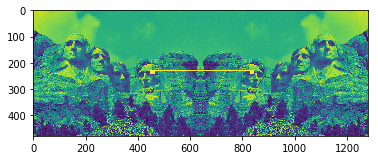

In [45]:
plt.imshow(new_image)

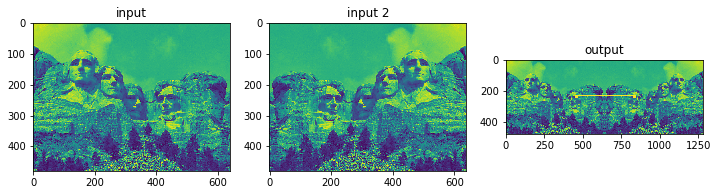

In [46]:
figure, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].set_title("input")
axes[0].imshow(image)
axes[1].set_title("input 2")
axes[1].imshow(flip_image)
axes[2].set_title("output")
axes[2].imshow(new_image)